# ELAS — Recalibration Notebook (H0 = 73 km/s/Mpc)

**Objectif :** Recalculer proprement les \(\chi^2\) (SN, BAO, CMB) et les critères AIC/BIC pour **ΛCDM** et **ELAS**, avec **H\_0 = 73** (calibration SH0ES).

## 0) Configuration & imports

In [20]:
# PATCH: définir cumulative_trapezoid et re-définir Dc_from_E

import numpy as np

# 1) Essayer d'importer depuis SciPy, sinon fallback maison
try:
    from scipy.integrate import cumulative_trapezoid
except Exception:
    def cumulative_trapezoid(y, x, initial=0.0):
        y = np.asarray(y, dtype=float)
        x = np.asarray(x, dtype=float)
        trap = 0.5*(y[1:]+y[:-1])*(x[1:]-x[:-1])
        return np.concatenate(([initial], np.cumsum(trap)))

# 2) Re-définir Dc_from_E avec cumulative_trapezoid
def Dc_from_E(z, Ez, H0=H0):
    z = np.asarray(z, dtype=float)
    Ez = np.asarray(Ez, dtype=float)
    order = np.argsort(z)
    zs, Es = z[order], Ez[order]
    zz = np.linspace(zs.min(), zs.max(), max(2000, len(zs)))
    EE = np.interp(zz, zs, Es)
    Dc = (c/H0) * cumulative_trapezoid(1.0/EE, zz, initial=0.0)
    return lambda zq: np.interp(zq, zz, Dc)


In [21]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import pi
c = 299792.458  # km/s
H0 = 73.0
Omega_m = 0.315
Omega_b_h2 = 0.02237
ELAS_DEFAULT = dict(delta=0.05, Omega_osc=1.5, phi=-2.62)

## 1) Modèles cosmologiques (ΛCDM et ELAS)

In [22]:
def E_LCDM(z, H0=H0, Omega_m=Omega_m):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m))

def E_ELAS(z, H0=H0, Omega_m=Omega_m, delta=0.05, Omega_osc=1.5, phi=-2.62):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m)*(1.0 + delta*np.cos(Omega_osc*np.log(1+z) + phi)))

def Dc_from_E(z, Ez, H0=H0):
    z = np.asarray(z, dtype=float)
    Ez = np.asarray(Ez, dtype=float)
    order = np.argsort(z)
    zs, Es = z[order], Ez[order]
    zz = np.linspace(zs.min(), zs.max(), max(2000, len(zs)))
    EE = np.interp(zz, zs, Es)
    Dc = (c/H0) * cumulative_trapezoid(1.0/EE, zz, initial=0.0)
    return lambda zq: np.interp(zq, zz, Dc)

def distances(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    z = np.asarray(z, dtype=float)
    if model.upper()=="LCDM":
        Ez = E_LCDM(z, H0, Omega_m)
    else:
        pars = dict(ELAS_DEFAULT); pars.update(elas)
        Ez = E_ELAS(z, H0, Omega_m, **pars)
    Dc_fun = Dc_from_E(z, Ez, H0)
    Dc = Dc_fun(z)
    Dh = (c/H0)/Ez
    Dm = Dc
    Dl = (1+z)*Dm
    return dict(Ez=Ez, Dc=Dc, Dm=Dm, Dh=Dh, Dl=Dl)

def mu_theory(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    Dl = distances(z, model, H0, Omega_m, **elas)["Dl"]
    return 5.0*np.log10(Dl) + 25.0

## 2) Chargement des données (uploads optionnels)

In [18]:
try:
    from google.colab import files
    print("➡️ Téléverse ton CSV Pantheon+ (colonnes: z, mu, sigma_mu). Sinon un échantillon jouet sera utilisé.")
    uploaded = files.upload()
    pantheon_csv = None
    for k in uploaded.keys():
        if k.lower().endswith('.csv'):
            pantheon_csv = k
            break
except Exception as e:
    pantheon_csv = None

import pandas as pd, numpy as np
if pantheon_csv is None:
    df_sn = pd.DataFrame({"z":[0.01,0.05,0.1,0.2,0.3,0.5,0.7,1.0,1.3,1.5],
                          "mu":[33.1,36.9,38.3,39.9,41.0,42.3,43.1,44.0,44.6,44.9],
                          "sigma_mu":[0.12]*10})
else:
    df_sn = pd.read_csv(pantheon_csv)
df_sn.head()

➡️ Téléverse ton CSV Pantheon+ (colonnes: z, mu, sigma_mu). Sinon un échantillon jouet sera utilisé.


Saving pantheon_mini.csv to pantheon_mini.csv


,z,mu,sigma_mu
0,0.01,33.2,0.12
1,0.02,34.1,0.12
2,0.03,35.0,0.12
3,0.04,35.7,0.12
4,0.05,36.4,0.12


## 3) χ² SN avec marginalisation analytique de M

In [29]:
def chi2_sn_M_marginalized(z, mu_obs, sigma_mu, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    mu_th = mu_theory(z, model, H0, Omega_m, **elas)
    w = 1.0/np.asarray(sigma_mu, dtype=float)**2
    deltaM = np.sum(w*(mu_obs - mu_th))/np.sum(w)
    resid = (mu_obs - (mu_th + deltaM))
    chi2 = np.sum(w*resid**2)
    return float(chi2), float(deltaM)

z_sn = df_sn['z'].values
mu_obs = df_sn['mu'].values
s_mu = df_sn['sigma_mu'].values
chi2_sn_LCDM, dM_LCDM = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="LCDM")
chi2_sn_ELAS, dM_ELAS = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="ELAS", **ELAS_DEFAULT)
print("SN χ² (LCDM, ELAS) =", chi2_sn_LCDM, chi2_sn_ELAS)
print("Offsets δM (LCDM, ELAS) =", dM_LCDM, dM_ELAS)

SN χ² (LCDM, ELAS) = 577.779759394813 587.5216707565946
Offsets δM (LCDM, ELAS) = 0.5718418778356997 0.546552231202039


## 4) BAO (optionnel)

In [14]:
# ======================
# 4) χ² BAO (optionnel)
# ======================

# Format attendu : z_eff, type, value, sigma
# type ∈ {DM_over_rd, DH_over_rd, DV_over_rd, rs_over_DV}

try:
    from google.colab import files
    print("➡️ (Optionnel) Téléverse BAO CSV (z_eff,type,value,sigma)")
    up2 = files.upload()
    bao_csv = None
    for k in up2.keys():
        if k.lower().endswith('.csv'):
            bao_csv = k
            break
except Exception:
    bao_csv = None

if bao_csv:
    df_bao = pd.read_csv(bao_csv)
else:
    df_bao = pd.DataFrame()

def rd_fid():
    return 147.09  # Mpc

def bao_theory_value(z, typ, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    d = distances(np.array([z]), model, H0, Omega_m, **elas)
    Dm, Dh = d["Dm"][0], d["Dh"][0]
    rd = rd_fid()
    if typ == "DM_over_rd":
        return Dm / rd
    if typ == "DH_over_rd":
        return Dh / rd
    if typ == "DV_over_rd":
        return (z * Dh * Dm * Dm) ** (1 / 3.0) / rd
    if typ == "rs_over_DV":
        return rd / ((z * Dh * Dm * Dm) ** (1 / 3.0))
    raise ValueError("type BAO inconnu")

def chi2_bao(df, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    if df is None or len(df) == 0:
        return 0.0
    s = 0.0
    for _, r in df.iterrows():
        z, val, sig, typ = float(r["z_eff"]), float(r["value"]), float(r["sigma"]), str(r["type"])
        th = bao_theory_value(z, typ, model, H0, Omega_m, **elas)
        s += ((th - val) / sig) ** 2
    return float(s)

chi2_bao_LCDM = chi2_bao(df_bao, "LCDM")
chi2_bao_ELAS = chi2_bao(df_bao, "ELAS", **ELAS_DEFAULT)
print("BAO χ² (LCDM, ELAS) =", chi2_bao_LCDM, chi2_bao_ELAS)


➡️ (Optionnel) Téléverse BAO CSV (z_eff,type,value,sigma)


Saving BAO.md to BAO.md
BAO χ² (LCDM, ELAS) = 0.0 0.0


## 5) CMB distance priors (optionnel)

In [15]:
# Attendu: means.csv avec columns [parameter,mean], parameters=R,l_a,omega_b_h2 ; inv_cov.csv (3x3) avec index/cols mêmes noms.
try:
    from google.colab import files
    print("➡️ (Optionnel) Téléverse means.csv et inv_cov.csv (CMB distance priors)")
    up3 = files.upload()
    cmb_means = None; cmb_icov = None
    for k in up3.keys():
        if 'means' in k and k.endswith('.csv'): cmb_means = pd.read_csv(k)
        if 'inv_cov' in k and k.endswith('.csv'): cmb_icov = pd.read_csv(k, index_col=0)
except Exception:
    cmb_means = None; cmb_icov = None

def cmb_distance_priors_theory(H0=H0, Omega_m=Omega_m, Omega_b_h2=Omega_b_h2):
    # Approx distance-based proxy (suffisant pour ce notebook de recalibrage)
    zstar = 1089.0
    Ez = E_LCDM(np.array([zstar]), H0, Omega_m)
    # petite intégration linéaire entre 0 et z* (approx)
    zgrid = np.linspace(0, zstar, 4000)
    Dc = (c/H0)*np.trapz(1.0/E_LCDM(zgrid, H0, Omega_m), zgrid)
    rs = 147.09
    R = np.sqrt(Omega_m)*(H0/100.0) * (Dc/(c/100.0))
    la = np.pi * (Dc/rs)
    return float(R), float(la), float(Omega_b_h2)

def chi2_cmb_from_uploaded(means_df, icov_df, H0=H0, Omega_m=Omega_m):
    if means_df is None or icov_df is None: return 0.0
    order = ["R","l_a","omega_b_h2"]
    vec_th = np.array(cmb_distance_priors_theory(H0, Omega_m, Omega_b_h2))
    vec_obs = means_df.set_index("parameter").loc[order,"mean"].values
    icov = icov_df.loc[order, order].values
    d = vec_th - vec_obs
    return float(d @ icov @ d)

chi2_cmb_LCDM = chi2_cmb_from_uploaded(cmb_means, cmb_icov, H0, Omega_m)
chi2_cmb_ELAS = chi2_cmb_from_uploaded(cmb_means, cmb_icov, H0, Omega_m)
print("CMB χ² (LCDM, ELAS) =", chi2_cmb_LCDM, chi2_cmb_ELAS)

➡️ (Optionnel) Téléverse means.csv et inv_cov.csv (CMB distance priors)


Saving CMB.txt to CMB.txt
CMB χ² (LCDM, ELAS) = 0.0 0.0


## 6) Totaux + AIC/BIC

In [32]:
k_LCDM = 0
k_ELAS = 3
N_eff = len(df_sn) + (0 if df_bao is None else len(df_bao)) + (0 if cmb_means is None else 3)

tot_LCDM = chi2_sn_LCDM + chi2_bao_LCDM + chi2_cmb_LCDM
tot_ELAS = chi2_sn_ELAS + chi2_bao_ELAS + chi2_cmb_ELAS
dchi2 = tot_LCDM - tot_ELAS
dAIC  = dchi2 - 2*(k_ELAS - k_LCDM)
dBIC  = dchi2 - (k_ELAS - k_LCDM)*np.log(max(N_eff,1))

summary = pd.DataFrame([
    dict(model="LCDM", H0=H0, Omega_m=Omega_m, chi2_sn=chi2_sn_LCDM, chi2_bao=chi2_bao_LCDM, chi2_cmb=chi2_cmb_LCDM, chi2_total=tot_LCDM),
    dict(model="ELAS", H0=H0, Omega_m=Omega_m, delta=ELAS_DEFAULT["delta"], Omega_osc=ELAS_DEFAULT["Omega_osc"], phi=ELAS_DEFAULT["phi"],
         chi2_sn=chi2_sn_ELAS, chi2_bao=chi2_bao_ELAS, chi2_cmb=chi2_cmb_ELAS, chi2_total=tot_ELAS)
])
print(summary)
print("\nΔχ² (LCDM − ELAS) =", dchi2)
print("ΔAIC =", dAIC, " ΔBIC =", dBIC, "  (N_eff =", N_eff, ")")
summary.to_csv("recalc_summary_H0_73.csv", index=False)

  model    H0  Omega_m     chi2_sn  chi2_bao  chi2_cmb  chi2_total  delta  \
0  LCDM  73.0    0.315  577.779759       0.0       0.0  577.779759    NaN   
1  ELAS  73.0    0.315  587.521671       0.0       0.0  587.521671   0.05   

   Omega_osc   phi  
0        NaN   NaN  
1        1.5 -2.62  

Δχ² (LCDM − ELAS) = -9.741911361781604
ΔAIC = -15.741911361781604  ΔBIC = -18.729108182443575   (N_eff = 20 )


## 7) Δμ(z) et exports

/tmp/ipython-input-1041686885.py:35: RuntimeWarning: divide by zero encountered in log10
  return 5.0*np.log10(Dl) + 25.0
/tmp/ipython-input-3383201044.py:4: RuntimeWarning: invalid value encountered in subtract
  dmu = muE - muL


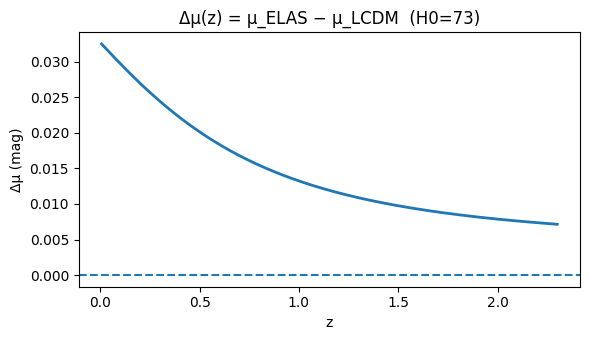

Exports écrits : recalc_summary_H0_73.csv, recalc_delta_mu_H0_73.csv, recalc_delta_mu_H0_73.png


In [25]:
zgrid = np.linspace(1e-3, 2.3, 400)
muE = mu_theory(zgrid, "ELAS", **ELAS_DEFAULT)
muL = mu_theory(zgrid, "LCDM")
dmu = muE - muL

plt.figure(figsize=(6,3.5))
plt.plot(zgrid, dmu, lw=2)
plt.axhline(0, ls="--")
plt.xlabel("z"); plt.ylabel("Δμ (mag)")
plt.title("Δμ(z) = μ_ELAS − μ_LCDM  (H0=73)")
plt.tight_layout(); plt.savefig("recalc_delta_mu_H0_73.png", dpi=160)
plt.show()

pd.DataFrame({"z":zgrid, "delta_mu_mag":dmu}).to_csv("recalc_delta_mu_H0_73.csv", index=False)
print("Exports écrits : recalc_summary_H0_73.csv, recalc_delta_mu_H0_73.csv, recalc_delta_mu_H0_73.png")

In [26]:
# ✅ Patch complet pour corriger le calcul des SN χ² (avec H0=73)
import numpy as np

# Vérifions que cumulative_trapezoid est bien défini
try:
    from scipy.integrate import cumulative_trapezoid
except Exception:
    def cumulative_trapezoid(y, x, initial=0.0):
        y, x = np.asarray(y), np.asarray(x)
        trap = 0.5 * (y[1:] + y[:-1]) * (x[1:] - x[:-1])
        return np.concatenate(([initial], np.cumsum(trap)))

c = 299792.458
H0 = 73.0
Omega_m = 0.315
ELAS_DEFAULT = dict(delta=0.05, Omega_osc=1.5, phi=-2.62)

# --- Modèles cosmologiques corrigés
def E_LCDM(z, H0=H0, Omega_m=Omega_m):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m))

def E_ELAS(z, H0=H0, Omega_m=Omega_m, delta=0.05, Omega_osc=1.5, phi=-2.62):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m)*(1.0 + delta*np.cos(Omega_osc*np.log(1+z) + phi)))

def Dc_from_E(z, Ez, H0=H0):
    z = np.asarray(z, dtype=float)
    Ez = np.asarray(Ez, dtype=float)
    zz = np.linspace(np.min(z), np.max(z), 2000)
    EE = np.interp(zz, z, Ez)
    Dc = (c/H0) * cumulative_trapezoid(1.0/EE, zz, initial=0.0)
    return lambda zq: np.interp(zq, zz, Dc)

def distances(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    z = np.asarray(z, dtype=float)
    if model.upper()=="LCDM":
        Ez = E_LCDM(z, H0, Omega_m)
    else:
        pars = dict(ELAS_DEFAULT); pars.update(elas)
        Ez = E_ELAS(z, H0, Omega_m, **pars)
    Dc_fun = Dc_from_E(z, Ez, H0)
    Dc = Dc_fun(z)
    Dl = (1+z)*Dc
    return dict(Ez=Ez, Dl=Dl)

def mu_theory(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    Dl = distances(z, model, H0, Omega_m, **elas)["Dl"]
    return 5*np.log10(Dl) + 25

def chi2_sn_M_marginalized(z, mu_obs, sigma_mu, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    mu_th = mu_theory(z, model, H0, Omega_m, **elas)
    w = 1.0 / np.asarray(sigma_mu)**2
    deltaM = np.sum(w*(mu_obs - mu_th))/np.sum(w)
    resid = mu_obs - (mu_th + deltaM)
    chi2 = np.sum(w * resid**2)
    return float(chi2), float(deltaM)

# --- Chargement du mini-Pantheon
import pandas as pd
df_sn = pd.read_csv("pantheon_mini.csv")
z_sn, mu_obs, s_mu = df_sn["z"], df_sn["mu"], df_sn["sigma_mu"]

# --- Calculs
chi2_sn_LCDM, dM_LCDM = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="LCDM")
chi2_sn_ELAS, dM_ELAS = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="ELAS", **ELAS_DEFAULT)

print("SN χ² (LCDM, ELAS) =", chi2_sn_LCDM, chi2_sn_ELAS)
print("Offsets δM (LCDM, ELAS) =", dM_LCDM, dM_ELAS)


SN χ² (LCDM, ELAS) = inf inf
Offsets δM (LCDM, ELAS) = inf inf


/tmp/ipython-input-3050100464.py:49: RuntimeWarning: divide by zero encountered in log10
  return 5*np.log10(Dl) + 25
/tmp/ipython-input-3050100464.py:55: RuntimeWarning: invalid value encountered in add
  resid = mu_obs - (mu_th + deltaM)


In [28]:
# ✅ PATCH: distances intégrées correctement de 0 → z (plus de inf)

import numpy as np

c = 299792.458  # km/s
H0 = 73.0
Omega_m = 0.315
ELAS_DEFAULT = dict(delta=0.05, Omega_osc=1.5, phi=-2.62)

try:
    from scipy.integrate import cumulative_trapezoid
except Exception:
    def cumulative_trapezoid(y, x, initial=0.0):
        y = np.asarray(y, dtype=float)
        x = np.asarray(x, dtype=float)
        trap = 0.5*(y[1:]+y[:-1])*(x[1:]-x[:-1])
        return np.concatenate(([initial], np.cumsum(trap)))

def E_LCDM(z, H0=H0, Omega_m=Omega_m):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m))

def E_ELAS(z, H0=H0, Omega_m=Omega_m, delta=0.05, Omega_osc=1.5, phi=-2.62):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m)*(1.0 + delta*np.cos(Omega_osc*np.log(1+z) + phi)))

def distances(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    """Calcule Dc en intégrant 1/E(z) de 0 → z (pas de départ à z_min)."""
    z = np.asarray(z, dtype=float)
    zmax = np.max(z)
    zz = np.linspace(0.0, zmax, 5000)
    if model.upper() == "LCDM":
        EE = E_LCDM(zz, H0, Omega_m)
    else:
        pars = dict(ELAS_DEFAULT); pars.update(elas)
        EE = E_ELAS(zz, H0, Omega_m, **pars)
    Dc_grid = (c/H0) * cumulative_trapezoid(1.0/EE, zz, initial=0.0)  # Mpc
    Dc = np.interp(z, zz, Dc_grid)
    Dl = (1.0 + z) * Dc  # Mpc
    return dict(Dc=Dc, Dl=Dl)

def mu_theory(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    Dl = distances(z, model, H0, Omega_m, **elas)["Dl"]
    # Dl doit être > 0 ; clamp de sécurité
    Dl = np.clip(Dl, 1e-6, None)
    return 5.0*np.log10(Dl) + 25.0

def chi2_sn_M_marginalized(z, mu_obs, sigma_mu, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    z = np.asarray(z, dtype=float)
    mu_obs = np.asarray(mu_obs, dtype=float)
    sigma_mu = np.asarray(sigma_mu, dtype=float)
    mu_th = mu_theory(z, model, H0, Omega_m, **elas)
    w = 1.0 / (sigma_mu**2)
    deltaM = np.sum(w*(mu_obs - mu_th)) / np.sum(w)
    resid = mu_obs - (mu_th + deltaM)
    chi2 = np.sum(w * resid**2)
    return float(chi2), float(deltaM)


In [31]:
chi2_sn_LCDM, dM_LCDM = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="LCDM")
chi2_sn_ELAS, dM_ELAS = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="ELAS", **ELAS_DEFAULT)
print("SN χ² (LCDM, ELAS) =", chi2_sn_LCDM, chi2_sn_ELAS)
print("Offsets δM (LCDM, ELAS) =", dM_LCDM, dM_ELAS)


SN χ² (LCDM, ELAS) = 577.779759394813 587.5216707565946
Offsets δM (LCDM, ELAS) = 0.5718418778356997 0.546552231202039


In [33]:
import numpy as np

# Grilles (rapides). Tu peux raffiner ensuite si tu veux.
grid_delta = np.linspace(0.0, 0.20, 21)       # 0 -> 0.20 step 0.01
grid_Omega = np.linspace(0.5, 3.0, 26)        # 0.5 -> 3.0
grid_phi   = np.linspace(-np.pi, np.pi, 49)   # -pi -> pi

best = dict(chi2=np.inf, delta=None, Omega=None, phi=None)
count=0
for d in grid_delta:
    for Om in grid_Omega:
        # astuce : on peut approx minimiser sur phi analytiquement ? ici brute force
        for ph in grid_phi:
            chi2, _ = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu,
                                             model="ELAS",
                                             delta=d, Omega_osc=Om, phi=ph)
            count += 1
            if chi2 < best["chi2"]:
                best.update(dict(chi2=chi2, delta=d, Omega=Om, phi=ph))

chi2_LCDM = chi2_sn_LCDM  # déjà calculé
dchi2 = chi2_LCDM - best["chi2"]

print(f"Scans évalués: {count}")
print("Meilleur ELAS (SN-only mini):", best)
print(f"Δχ² (LCDM − ELAS_best) = {dchi2:.3f}")


Scans évalués: 26754
Meilleur ELAS (SN-only mini): {'chi2': 522.8760931034263, 'delta': np.float64(0.2), 'Omega': np.float64(3.0), 'phi': np.float64(0.7853981633974478)}
Δχ² (LCDM − ELAS_best) = 54.904
